3. Use the Darksky.net API https://darksky.net/dev/docs/time-machine to download 1 month of hourly data for a given zip code.

4. Convert the JSON data from the Darkskey.net API to a table with "time" as the index. Export this table as a .CSV.

5. For the 1 month of data, find the average, min, and max temperatures and wind speeds of each day. Plot the statistics over time.

7. Predict the windiest hour and the coldest hour of tomorrow.

### Set constants in next cell

Set the target zip code for which you wish to retrieve past weather history `TARGET_ZIP_CODE`.

Retrieve an API key for the ZipCodeAPI with an auto generated API key supporting fewer than 50 requests / second:
https://www.zipcodeapi.com/API#zipToLoc. Set the `ZIPCODE_API_KEY`.

Retrieve an API key from the DarkSky API:
https://darksky.net/dev/. Set the `DARKSKEY_API_KEY`.

Set the `NUMBER_OF_PREVIOUS_DAYS` variable to the number of days prior to today which you would like to retrieve and analyze from the Dark Sky API

In [1]:
import requests
import json
import sys
import os

from envs import env
from jsonpath_rw import jsonpath, parse
import pandas as pd
import numpy as np

In [2]:
TARGET_ZIP_CODE=27705
ZIPCODE_API_KEY = env("ZIPCODE_API_KEY")
DARKSKY_API_KEY = env("DARKSKY_API_KEY")
NUMBER_OF_PREVIOUS_DAYS = 30

In [4]:
class DarkskyClient():


    """ DarkSky API client. Consumes https://darksky.net/dev/docs/time-machine API.


    """
    def __init__(self, key, latitude, longitude, **request_params):
      
        """
        Constructor for the client. 
        
        Parameters
        ----------
        key : string
            DarkSky API key
        latitude : string
            latitude of location
        longitude : string
            longitude of location
            
        """
        self._BASE_URL = 'https://api.darksky.net/forecast'
        self.key = key
        self.latitude = latitude
        self.longitude = longitude
        self._request_params = request_params

    
    def __buildUrl__(self, time):

        """
        Build the URL for the request to the DarkSky API
        
        Parameters
        ----------
        time : string, optional
            ISO format time with millisecond resolution.

        Returns
        -------
        url : string
            URL for making a request to the DarkSky API
        """
        timeStr = ',{}'.format(time) if time else ''
        url = "{_BASE_URL}/{key}/{latitude},{longitude}{timeStr}".format(
            timeStr=timeStr, **self.__dict__)

        return url

    def getForecast(self, time=None):

        """
        Send a request to the DarkSky API
        
        Parameters
        ----------
        time : string, optional
            ISO format time with millisecond resolution.

        Returns
        -------
        body : object
            body from request response
        """
        
        # build the url to make the request
        url = self.__buildUrl__(time)
        
        # add any additional request parameters
        request_params = {"params": self._request_params}
        try:
            response = requests.get(url, **request_params)
        except requests.RequestException as exception:
            print(exception)
            sys.exit(1)

        # convert the response body text to a json object
        body = json.loads(response.text)

        return body

def json2df(data, json_parent_expr=None):
    
    '''
    Converts a JSON object to a dataframe.

    Parameters
    ----------
    data : object
        json data to convert.
    json_parent_expr : string
        json path to retrieve subset of json object to convert to a dataframe.

    Returns
    -------
    df : pandas.DataFrame
        data frame converted from JSON returned from the json_parent_expr query.
        
    Examples
    --------
    
    '''
    
    # if defined use the json path specified
    # else use the root property
    if json_parent_expr:
        base_expr = parse(json_parent_expr)
    
        # get the data specified by the json path expression
        subset = [match.value for match in base_expr.find(data)]
    else:
        subset = data

    # convert json to a pandas dataframe
    df = pd.read_json(json.dumps(subset))
    
    return df
  
class ZipCodeApiClient():


    """ ZipCodeAPI API client. Consumes https://www.zipcodeapi.com/API API.
    Geocodes zip codes.


    """
    def __init__(self, key, zip_code=None, **request_params):
      
        """
        Constructor for the client. 
        
        Parameters
        ----------
        key : string
            Zip Code API key
        zip_code : string
            5-digit zip code to geocode
        
            
        """
        self._BASE_URL = 'https://www.zipcodeapi.com/rest/'
        self.key = key
        self.zip_code = zip_code
        self._request_params = request_params

    
    def __buildUrl__(self):

        """
        Build the URL for the request to the ZipCode API
        
        Parameters
        ----------

            
        Returns
        -------
        url : string
            URL for making a request to the ZipCode API
        """

        url = "{_BASE_URL}/{key}/info.json/{zip_code}/degrees".format(**self.__dict__)

        return url

    def getGeoCoding(self, zip_code=None, **request_params):

        """
        Send a request to the ZipCode API
        
        Parameters
        ----------
        zip_code : string
            5-digit zip code to geocode
        
        Returns
        -------
        body : object
            body from request response
        """
        if zip_code:  self.zip_code = zip_code 
        if request_params:  self._request_params = request_params 

        # build the url to make the request
        url = self.__buildUrl__()
        # add any additional request parameters
        request_params = {"params": self._request_params}
        try:
            response = requests.get(url, **request_params)
        except requests.RequestException as exception:
            print(exception)
            sys.exit(1)

        # convert the response body text to a json object
        body = json.loads(response.text)

        return body



In [5]:
ZIPCODE_API_KEY

'8Xraj6j0sd1XUegnY0z2vukFSRD3ymfBoffrDuWpwmk9S3IN4AAEsd5H59c43IHO'

In [6]:
# Geo code the zip code with the Zip Code API
# https://www.zipcodeapi.com/API#zipToLoc
zipCodeClient = ZipCodeApiClient(ZIPCODE_API_KEY, 
                                 TARGET_ZIP_CODE)

# send a request to the API
zip_code_info = zipCodeClient.getGeoCoding()

# retrieve the longitude and latitude of the zip code necessary for the Dark Sky API
target_latitude, target_longitude = zip_code_info['lat'], zip_code_info['lng']
target_city = zip_code_info['city']
print('Target city: ' + target_city)

Target city: Durham


In [7]:
# Ask to exclude unused data
request_params = {"exclude": "minutely,daily,alerts,flags,currently"}

# create a client instance for the location
dsClient = DarkskyClient(DARKSKY_API_KEY, 
                         target_latitude, 
                         target_longitude,
                         **request_params)


In [8]:
from datetime import datetime as dt
from datetime import timedelta
import datetime

# get the times for the last 30 days to query the time machine API
# no attention has been paid to timezones...
forecasts = []
for i in range(0, NUMBER_OF_PREVIOUS_DAYS):
  # get a date from the past
  # remove any microseconds in order to support second-resolution required by the DarkSky API
  time = (dt.now() - timedelta(days=i)).replace(microsecond=0)
  forecasts.append(
    {"time": time
    }
  )

# show the first object in the list
forecasts[0]


{'time': datetime.datetime(2020, 3, 7, 1, 38, 47)}

In [9]:
# request weather for each date in the forecasts list
# time must be in unix format or iso format with second resolution
for forecast in forecasts:
  forecast["response"] = dsClient.getForecast(forecast["time"].isoformat())


In [10]:

# convert each response to a dataframe
# ------------------------------------
# weather data in response will be a list with parent properties of 
# hourly/data/, minutely/data/, or daily/data/.
# use jsonpath-rw in order to query the JSON object for the list in the 
# data property despite which time resolution is requested
for forecast in forecasts:
  forecast['df'] = json2df(forecast["response"], json_parent_expr="*.data[*]")

# merge all the data frames
# -------------------------
# put the data frames in a list for concatenating
dfs = []
for forecast in forecasts:
    dfs.append(forecast["df"])
    
# concatenate the data frames
df = pd.concat(dfs)

# create a new datetime column from the unix time provided by the Dark Sky API
df["date"] = pd.to_datetime(df["time"],unit="s")

# set the index of the weather data to the datetime
df = df.set_index(df['date'], drop=False)
df

,time,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation,date
date,,,,,,,,,,,,,,,,,,,,
2020-03-07 05:00:00,1583557200,Clear,clear-night,0.0020,0.03,rain,39.03,30.97,28.47,0.66,1020.3,13.82,31.73,313,0.01,0,10.0,398.3,NaN,2020-03-07 05:00:00
2020-03-07 06:00:00,1583560800,Clear,clear-night,0.0020,0.02,rain,38.27,30.14,28.18,0.67,1020.8,13.45,31.19,316,0.01,0,10.0,396.7,NaN,2020-03-07 06:00:00
2020-03-07 07:00:00,1583564400,Clear,clear-night,0.0000,0.00,NaN,37.55,29.29,27.37,0.66,1021.5,13.28,30.82,319,0.01,0,10.0,395.0,NaN,2020-03-07 07:00:00
2020-03-07 08:00:00,1583568000,Clear,clear-night,0.0000,0.00,NaN,36.79,28.40,26.38,0.66,1022.1,13.04,30.37,322,0.00,0,10.0,392.6,NaN,2020-03-07 08:00:00
2020-03-07 09:00:00,1583571600,Clear,clear-night,0.0018,0.02,rain,36.04,27.43,25.55,0.65,1022.8,13.11,29.23,325,0.00,0,10.0,389.7,NaN,2020-03-07 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-08 00:00:00,1581120000,Clear,clear-night,0.0000,0.00,NaN,41.39,35.57,24.68,0.51,1011.7,9.52,21.66,278,0.13,0,10.0,340.2,NaN,2020-02-08 00:00:00
2020-02-08 01:00:00,1581123600,Clear,clear-night,0.0000,0.00,NaN,39.90,34.58,24.83,0.55,1013.7,7.79,20.45,281,0.09,0,10.0,343.7,NaN,2020-02-08 01:00:00
2020-02-08 02:00:00,1581127200,Clear,clear-night,0.0000,0.00,NaN,38.47,33.15,25.79,0.60,1015.5,7.25,17.31,293,0.04,0,10.0,347.4,NaN,2020-02-08 02:00:00


In [15]:
# get the minimum and maximum time of the data to write in the filename
time_min = min(df["date"]).isoformat()
time_max = max(df["date"]).isoformat()

# build the filename 
filename = "weather_{time_min}_to_{time_max}.csv".format(time_min=time_min, time_max=time_max)
                                                   
# export the csv content to a string without the index
csv_content = df.to_csv('data/weather.csv', index=False)





# Visualize Weather Data

In [29]:
# resample data to get 24-hour statistics
df_mean = df.resample('24h').mean()
# df_min = df.resample('24h').min()
# df_max = df.resample('24h').max()
df_mean


,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
date,,,,,,,,,,,,,,,,
2020-02-07,1.581084e+09,0.013184,0.237368,53.311053,51.248421,44.795263,0.750526,996.789474,14.336316,30.280000,224.526316,0.555263,0.947368,9.066789,306.273684,NaN
2020-02-08,1.581161e+09,0.000204,0.002917,37.580417,34.844583,24.695833,0.611250,1022.425000,4.561250,10.102917,254.500000,0.184583,0.708333,10.000000,337.825000,0.004050
2020-02-09,1.581248e+09,0.000475,0.016250,40.932083,39.365833,31.591667,0.736667,1031.091667,3.443750,7.767500,208.833333,0.287083,0.875000,10.000000,304.037500,0.002950
2020-02-10,1.581334e+09,0.000304,0.010000,45.863333,43.690417,38.510000,0.758750,1027.479167,5.300000,13.838750,199.666667,0.496250,0.750000,10.000000,279.195833,NaN
2020-02-11,1.581421e+09,0.020387,0.334583,61.676667,62.070000,59.947083,0.940833,1015.891667,8.238750,24.453333,202.083333,0.915833,0.750000,9.582375,273.629167,NaN
2020-02-12,1.581507e+09,0.001583,0.059167,54.768333,54.582083,50.012917,0.840000,1018.650000,5.571667,13.545833,184.250000,0.877083,0.750000,10.000000,277.550000,NaN
2020-02-13,1.581593e+09,0.016421,0.247500,58.930000,59.167500,56.490417,0.917083,1010.608333,7.583750,20.927500,179.041667,0.907917,0.791667,9.888958,278.375000,NaN
2020-02-14,1.581680e+09,0.000617,0.020417,46.519583,43.930000,33.849167,0.637500,1022.470833,7.111250,16.609167,322.958333,0.476667,0.875000,10.000000,284.029167,NaN
2020-02-15,1.581766e+09,0.000250,0.004583,34.952083,30.278333,18.037917,0.512083,1033.729167,5.454167,11.855833,76.958333,0.091250,0.916667,10.000000,315.958333,0.004771


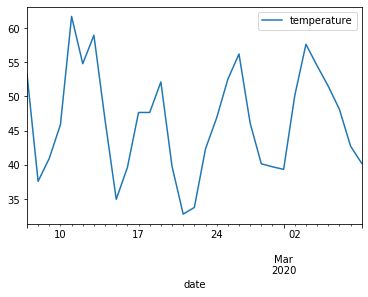

In [32]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
df_mean.plot(y='temperature')

# ax = df_mean.plot(df_mean.index, y='temperature', marker='', linewidth=3, color='k', label='Average')
# ax.fill_between(df_mean.index, df_min['temperature'], df_max['temperature'], color='k', alpha=0.5, label='Range')

# ax.set_xlabel('Date')
# ax.set_ylabel('Temperature [deg F]')
# plt.title('Temperature in ' + target_city + ' in last ' + str(NUMBER_OF_PREVIOUS_DAYS) + ' days')
# plt.tight_layout()
# plt.legend(loc='upper right')
# display(plt.show())

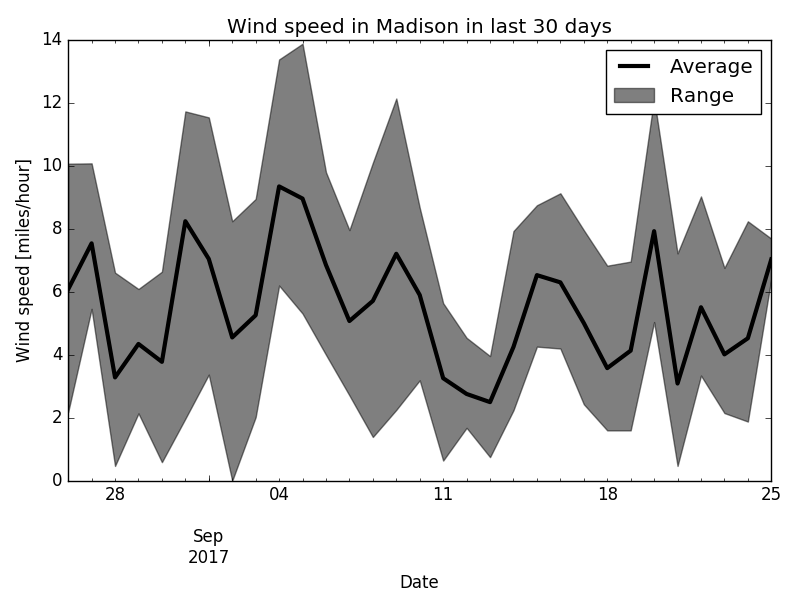

In [14]:
import matplotlib.dates as mdates

ax = df_mean.plot(df_mean.index, y='windSpeed', marker='', linewidth=3, color='k', label='Average')
ax.fill_between(df_mean.index, df_min['windSpeed'], df_max['windSpeed'], facecolor='k', alpha=0.5, label='Range')

ax.set_xlabel('Date')

ax.set_ylabel('Wind speed [miles/hour]')
plt.title('Wind speed in ' + target_city + ' in last ' + str(NUMBER_OF_PREVIOUS_DAYS) + ' days')
plt.tight_layout()
plt.legend(loc='upper right')
display(plt.show())

# Train Predictive Model for Wind and Temperature

In [34]:
# copy the orginal dataset
df_for_modeling = df[['time', 'temperature']].copy()

# drop columns that will not be used to train the model
# -----------------------------------------------------
# drop categorical columns and columns equivalant to the time index
#df_for_modeling.drop(['date', 'icon', 'summary', 'precipType', 'time'], axis=1, inplace=True)

# drop columns with NaNs
df_for_modeling.dropna(axis=0, inplace=True)

# split the model into a train, validate and test set
def split_df(df, frac_train=0.5, frac_validate=0.25, frac_test=0.25):
    """
    Splits array into three randomly sampled 
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe to generate three datasets
    frac_train : double
        fraction of dataframe to sample as a training set
    frac_validate : double
        fraction of dataframe to sample as a validate set
    frac_test : double
        fraction of dataframe to sample as a test set
        
    Returns
    -------
    df_train : pandas.DataFrame
        training set
    df_validate : pandas.DataFrame
        validate set
    df_test : pandas.DataFrame
        test set
    """
    
    return np.split(df.sample(frac=1), 
                    [int((1 - frac_test - frac_validate)*len(df)), 
                     int((1 - frac_test)*len(df_for_modeling))])

df_for_modeling['time'] = pd.to_numeric(df_for_modeling['time'])

# split the data into train test and validate sets
# only using one model for now so no need tfor a validation set
df_train, df_validate, df_test = split_df(df_for_modeling, frac_train=0.7, frac_validate=0.0, frac_test=0.3)

# data are randomly sampled, sort them by the date index
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)
df_validate.sort_index(inplace=True)

df_for_modeling

,time,temperature
date,,
2020-03-07 05:00:00,1583557200,39.03
2020-03-07 06:00:00,1583560800,38.27
2020-03-07 07:00:00,1583564400,37.55
2020-03-07 08:00:00,1583568000,36.79
2020-03-07 09:00:00,1583571600,36.04
...,...,...
2020-02-08 00:00:00,1581120000,41.39
2020-02-08 01:00:00,1581123600,39.90
2020-02-08 02:00:00,1581127200,38.47


In [49]:
# copy the orginal dataset
df_for_modeling = df[['time', 'temperature',]].copy()

# drop columns that will not be used to train the model
# -----------------------------------------------------
# drop categorical columns and columns equivalant to the time index
#df_for_modeling.drop(['date', 'icon', 'summary', 'precipType', 'time'], axis=1, inplace=True)

# drop times with NaNs
df_for_modeling.dropna(axis=0, inplace=True)

# split the model into a train, validate and test set
def split_df(df, frac_train=0.5, frac_validate=0.25, frac_test=0.25):
    """
    Splits array into three randomly sampled 
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe to generate three datasets
    frac_train : double
        fraction of dataframe to sample as a training set
    frac_validate : double
        fraction of dataframe to sample as a validate set
    frac_test : double
        fraction of dataframe to sample as a test set
        
    Returns
    -------
    df_train : pandas.DataFrame
        training set
    df_validate : pandas.DataFrame
        validate set
    df_test : pandas.DataFrame
        test set
    """
    
    return np.split(df.sample(frac=1), 
                    [int((1 - frac_test - frac_validate)*len(df)), 
                     int((1 - frac_test)*len(df_for_modeling))])

df_for_modeling['time'] = pd.to_numeric(df_for_modeling['time'])

# split the data into train test and validate sets
# only using one model for now so no need tfor a validation set
df_train, df_validate, df_test = split_df(df_for_modeling, frac_train=0.7, frac_validate=0.0, frac_test=0.3)

# data are randomly sampled, sort them by the date index
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)
df_validate.sort_index(inplace=True)

# create dict for storing train, validate, and test data and labels for different quanties to predict
results_dict = {}

# quantities to predict are temperature and windspeed
feature_columns = ['temperature',]
for feature_column in feature_columns:
    
    # get the label instances from the data
    df_train_label = df_train[feature_column].copy()
    df_validate_label = df_validate[feature_column].copy()
    df_test_label = df_test[feature_column].copy()

    # remove the label instances from the data
    df_train_predictor = df_train.drop(feature_columns, axis=1)
    df_validate_predictor = df_validate.drop(feature_columns, axis=1)
    df_test_predictor = df_test.drop(feature_columns, axis=1)

    # add data and labels to dict
    results_dict[feature_column] = {"data": {
                                   "train" : {"predictor": df_train_predictor,
                                              "label": df_train_label},
                                   "validate" : {"predictor": df_validate_predictor,
                                                 "label": df_validate_label},
                                   "test" : {"predictor": df_test_predictor,
                                             "label": df_test_label}
                                  }
                                }


    print(df_train_predictor.info(), df_train_label)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2020-02-07 05:00:00 to 2020-03-08 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   time    503 non-null    int64
dtypes: int64(1)
memory usage: 7.9 KB
None date
2020-02-07 05:00:00    58.99
2020-02-07 06:00:00    58.90
2020-02-07 07:00:00    59.49
2020-02-07 08:00:00    59.48
2020-02-07 10:00:00    58.58
                       ...  
2020-03-08 00:00:00    44.45
2020-03-08 01:00:00    42.01
2020-03-08 02:00:00    39.82
2020-03-08 03:00:00    38.07
2020-03-08 04:00:00    36.62
Name: temperature, Length: 503, dtype: float64


In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ExpSineSquared, ConstantKernel

# use gaussian process regressor in order to support auto-correlation

# for each label feature train models
for label_feature in results_dict:
    result = results_dict[label_feature]
    df_train = result["data"]["train"]["predictor"]
    df_test = result["data"]["test"]["predictor"]
    df_train_label = result["data"]["train"]["label"]
    df_test_label = result["data"]["test"]["label"]

    # use a constant, matern and exponential sine squared kernel to support a locally-periodic prediction
    # see http://www.cs.toronto.edu/~duvenaud/cookbook/index.html for more details
    length_scale =3600.0
    periodicity = 3600.0 * 8
    nu = 0.2
    kernel = ConstantKernel(1) + Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 1e6), nu=nu) * ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    # kernel = ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    gpr = GaussianProcessRegressor(kernel=kernel)
    # fit the train data
    gpr.fit(df_train, df_train_label)
    
    # predict using the test data
    predict, sigma = gpr.predict(df_test, return_std=True)

     # save the results 
    results_dict[label_feature]["model"] = {
      "fitted": gpr,
      "mse": mean_squared_error(df_test_label, predict)
      }


In [38]:
plt.clf()
figure, axes = plt.subplots(len(results_dict), sharex=True, figsize=(10,10))

for i, label_feature in enumerate(results_dict):
    # get the test data and the predictive model
    df_test = results_dict[label_feature]['data']['test']['predictor']
    df_test_label = results_dict[label_feature]['data']['test']['label']
    model = results_dict[label_feature]['model']['fitted']

    # run the prediction on the test data
    pred = model.predict(df_test)

    # plot the actual data
    axes[i].plot(df_test.index, df_test_label, marker='', linewidth=2, alpha=1, label='Actual', color='k')

    # plot the prediction
    axes[i].plot(df_test.index, pred, marker='', linewidth=4, alpha=0.5, label="Prediction")
  
    axes[i].set_ylabel(label_feature)
    plt.legend()
    
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)

plt.tight_layout()

display(plt.show())

TypeError: 'AxesSubplot' object is not subscriptable

<Figure size 432x288 with 0 Axes>

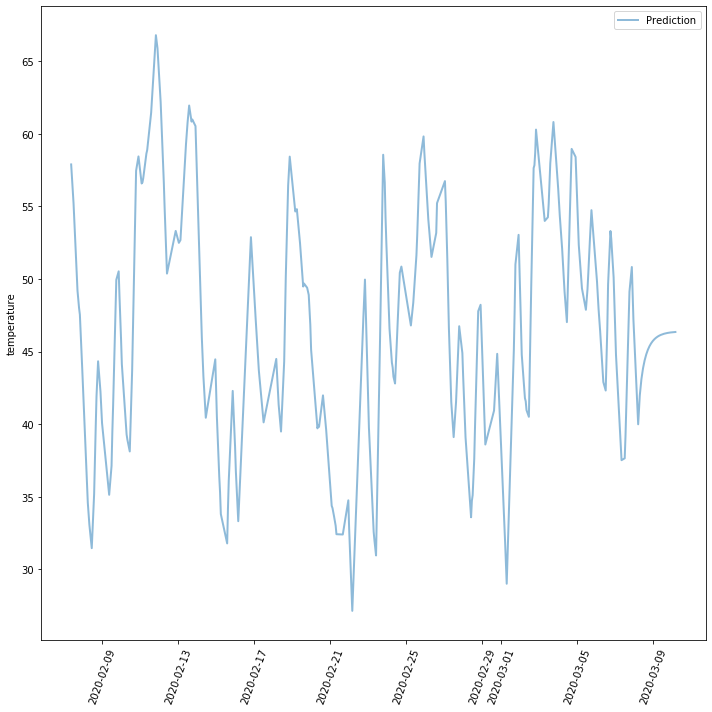

None

In [64]:
from datetime import datetime as dt
from datetime import timedelta
import datetime

plt.clf()
figure, axes = plt.subplots(len(results_dict), sharex=True, figsize=(10,10))

# get the time for tomorrow, add the number of seconds in a day to the max time in data
time = df['time'].max() + np.array(np.linspace(3600, 2 * 3600 * 24, 24), dtype=int)
df_tomorrow = pd.DataFrame({'time': time})
df_tomorrow['date'] = pd.to_datetime(df_tomorrow["time"],unit="s")
df_tomorrow.set_index('date', inplace=True)

for i, label_feature in enumerate(results_dict):
  
    # get the model to predict with the new time
    model = results_dict[label_feature]['model']['fitted']
    df_test = results_dict[label_feature]['data']['test']['predictor']
    df_extended = pd.concat([df_tomorrow, df_test])
    df_extended.sort_index(inplace=True)
    
    # run the prediction on the test data
    y = model.predict(df_extended)

    # plot the prediction
    axes.plot(df_extended.index, y, marker='', linewidth=2, alpha=0.5, label="Prediction")
    axes.set_ylabel(label_feature)
    plt.legend()
    
# rotate the ticks
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.tight_layout()
display(plt.show())


In [40]:
model = results_dict['temperature']['model']['fitted']

# predict values for tomorrow
y_tomorrow = model.predict(df_tomorrow)

# get the row for the statistic
iloc = np.argmin(y_tomorrow)

# get the value of the statistic
value = np.min(y_tomorrow)
hour = df_tomorrow.iloc[iloc].name
print('Temperature of ' + str(value) + ' deg F at ' + str(hour))

Temperature of 40.06703202300923 deg F at 2020-03-08 05:00:00


In [41]:
model = results_dict['windSpeed']['model']['fitted']

# predict values for tomorrow
y_tomorrow = model.predict(df_tomorrow)

# get the row for the statistic
iloc = np.argmax(y_tomorrow)

# get the value of the statistic
value = np.max(y_tomorrow)
hour = df_tomorrow.iloc[iloc].name
print('Wind Speed of ' + str(value) + ' mph at ' + str(hour))

KeyError: 'windSpeed'